Possible project to-dos:
- Implement dummy BED file generator based on FASTAs? (possibly implemented in samtools)
- Integrate orthology pipeline
- Add in overlapping translocation events to the rearrangements function (not sure if this is possible)
- Add in reciprocal translocations - maybe with probabilities to determine which type of translocation should be used?
- Check all species combinations to make sure results are consistent with (Sikamov 2022) findings?
- Update the colour coding of orthoplot output to match ancestral chromosomes like in the sample Oxford plot?
- Documentation?

Files:
- Macrosimulator.py: Elise's original simulator code
- ancestor.py: code to generate Bilaterian ancestor & Animal ancestor (based on the sponge genelist and events from (Sikamov, 2022))
- simtest.py: code to test the simulator
- simulator.py: my version of the simulator, but a better version of this is in the syntiny.py file
- Old code + snippets.ipynb

Functions in the syntiny file:
- readBED: read in a BED file
- orthFix: removes any suffix/prefix from ortholog data to standardise inputs
- unscaff: removes all genelist entries from non-chromosomal scaffolds (based on the number of genes)
- orthologies: returns a dataframe with the number of orthologs for each pair of chromosomes
- sigorthologies: returns a dataframe with orthologies between significant chromosome pairs, conducting hypergeometric testing
- orthoplot: plots an oxford plot of orthologies between two species
- rearrangements: counts and classifies the chromosomal rearrangements 
- simulator: simulates random chromosomal rearregements, returns dummy BED + genelist, and a list of events

## Imports

In [23]:
# Import packages
import pandas as pd
import numpy as np

import re
import sys # use to access arguments
import os 

import scipy.stats as stats
import pingouin as pg

import random
from random import randrange

import matplotlib.pyplot as plt

import seaborn as sns

import argparse

import syntiny

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [8, 8]
pd.options.mode.chained_assignment = None 

#### Import genelists

In [11]:
# Asterias rubens
Astrub = syntiny.readBED("Data/Genelists/Asterias.rubens.genelist.bed")

# Holothuria leucospilota
Holleu = syntiny.readBED("Data/Genelists/Holothuria.leucospilota.genelist.bed")

# Paracentrotus livides
Parliv = syntiny.readBED("Data/Genelists/Paracentrotus.lividus.genelist.bed")

# Branchiostoma lanceolatum
Bralan = syntiny.readBED("Data/Genelists/Branchiostoma.lanceolatum.genelist.bed")

# Branchiostoma floridae
Braflo = syntiny.readBED("Data/Genelists/Branchiostoma.floridae.genelist.bed", 's')

# Marthasterias glacialis
Margla = syntiny.readBED("Data/Genelists/Marthasterias.glacialis.genelist.bed")

# Pecten maximus
Pecmax = syntiny.readBED("Data/Genelists/Pecmax.genelist.bed", 's')

# Stichopus chloronotus
Stichl = syntiny.readBED("Data/Genelists/Stichopus.chloronotus.genelist.bed")

# Amphiura filiformis 
Ampfil = syntiny.readBED("Data/Genelists/Amphiura.filiformis.genelist.bed")

# Ephydatia muelleri
Ephmue = syntiny.readBED("Data/Genelists/Ephmue.genelist.bed", 's')

# Ancestor 
AniAnc = syntiny.readBED("Data/Genelists/AniAnc.genelist.bed", 's')
BilAnc = syntiny.readBED("Data/Genelists/BilAnc.genelist.bed", 's')

#### Import ortholog files

In [12]:
# Import orthologs
Astrub_Holleu = np.loadtxt("Data/Orthologs/Asterias.rubens+Holothuria.leucospilota.txt", dtype = "str")

Astrub_Parliv = np.loadtxt("Data/Orthologs/Asterias.rubens+Paracentrotus.lividus.txt", dtype = "str")

Holleu_Parliv = np.loadtxt("Data/Orthologs/Holothuria.leucospilota+Paracentrotus.lividus.txt", dtype = "str")

Margla_Bralan = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Branchiostoma.lanceolatum.txt", dtype = "str")

Margla_Pecmax = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Pecten.maximus.txt", dtype = "str")

Margla_Stichl = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Stichopus.chloronotus.txt", dtype = "str")

Pecmax_Bralan = np.loadtxt("Data/Orthologs/Pecten.maximus+Branchiostoma.lanceolatum.txt", dtype = "str")

Stichl_Bralan = np.loadtxt("Data/Orthologs/Stichopus.chloronotus+Branchiostoma.lanceolatum.txt", dtype = "str")

Stichl_Pecmax = np.loadtxt("Data/Orthologs/Stichopus.chloronotus+Pecten.maximus.txt", dtype = "str")

Pecmax_Holleu = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Holleu_sensitive.txt", dtype = "str")

Holleu_Bralan = np.loadtxt("Orthology pipeline/orthologs/Holleu+Bralan_sensitive.txt", dtype = "str")

Pecmax_Bralan = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Bralan_sensitive.txt", dtype = "str")

Pecmax_Braflo = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Braflo_sensitive.txt", dtype = "str")

Holleu_Braflo = np.loadtxt("Orthology pipeline/orthologs/Holleu+Braflo_sensitive.txt", dtype = "str")

Holleu_Ampfil = np.loadtxt("Data/Orthologs/Holothuria.leucospilota+Amphiura.filiformis.txt", dtype = "str")

Braflo_Ephmue = np.loadtxt("Orthology pipeline/orthologs/Braflo+Ephmue_sensitive.txt", dtype = "str")

Holleu_Ephmue = np.loadtxt("Orthology pipeline/orthologs/Holleu+Ephmue_sensitive.txt", dtype = "str")

Pecmax_Ephmue = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Ephmue_sensitive.txt", dtype = "str")

#### Sorting out the data

In [13]:
Astrub = Astrub.loc[Astrub['Chromosome'].str.contains('chr')]
Bralan = Bralan.loc[Bralan['Chromosome'].str.contains('BFL_')]
Braflo = Braflo.loc[Braflo['Chromosome'].str.contains('BFL_')]
Pecmax = Pecmax.loc[Pecmax['Chromosome'].str.contains('PYE_')]
Ephmue = Ephmue.loc[Ephmue['Chromosome'].str.contains('EMU_')]

# Ephmue genelist: remove suffix
Ephmue['Name'] = Ephmue['Name'].str.rsplit('.t1').str.get(0)

# Parliv genelist: select chromosomal scaffolds
Parliv = syntiny.unscaff(Parliv, 100)
Ampfil = syntiny.unscaff(Ampfil, 100)
Ephmue = syntiny.unscaff(Ephmue, 600)

Astrub_Parliv = syntiny.orthFix(Astrub_Parliv, 'B', 'Parliv_', 1)
Margla_Bralan = syntiny.orthFix(Margla_Bralan, 'A', '.1', 0)
Margla_Stichl = syntiny.orthFix(Margla_Stichl, 'A', '.1', 0)
Margla_Stichl = syntiny.orthFix(Margla_Stichl, 'B', '.1', 0)
Margla_Pecmax = syntiny.orthFix(Margla_Pecmax, 'B', '.1', 0)
Holleu_Ampfil = syntiny.orthFix(Holleu_Ampfil, 'B', '.1', 0)
Holleu_Bralan = syntiny.orthFix(Holleu_Bralan, 'B', '_', 0)

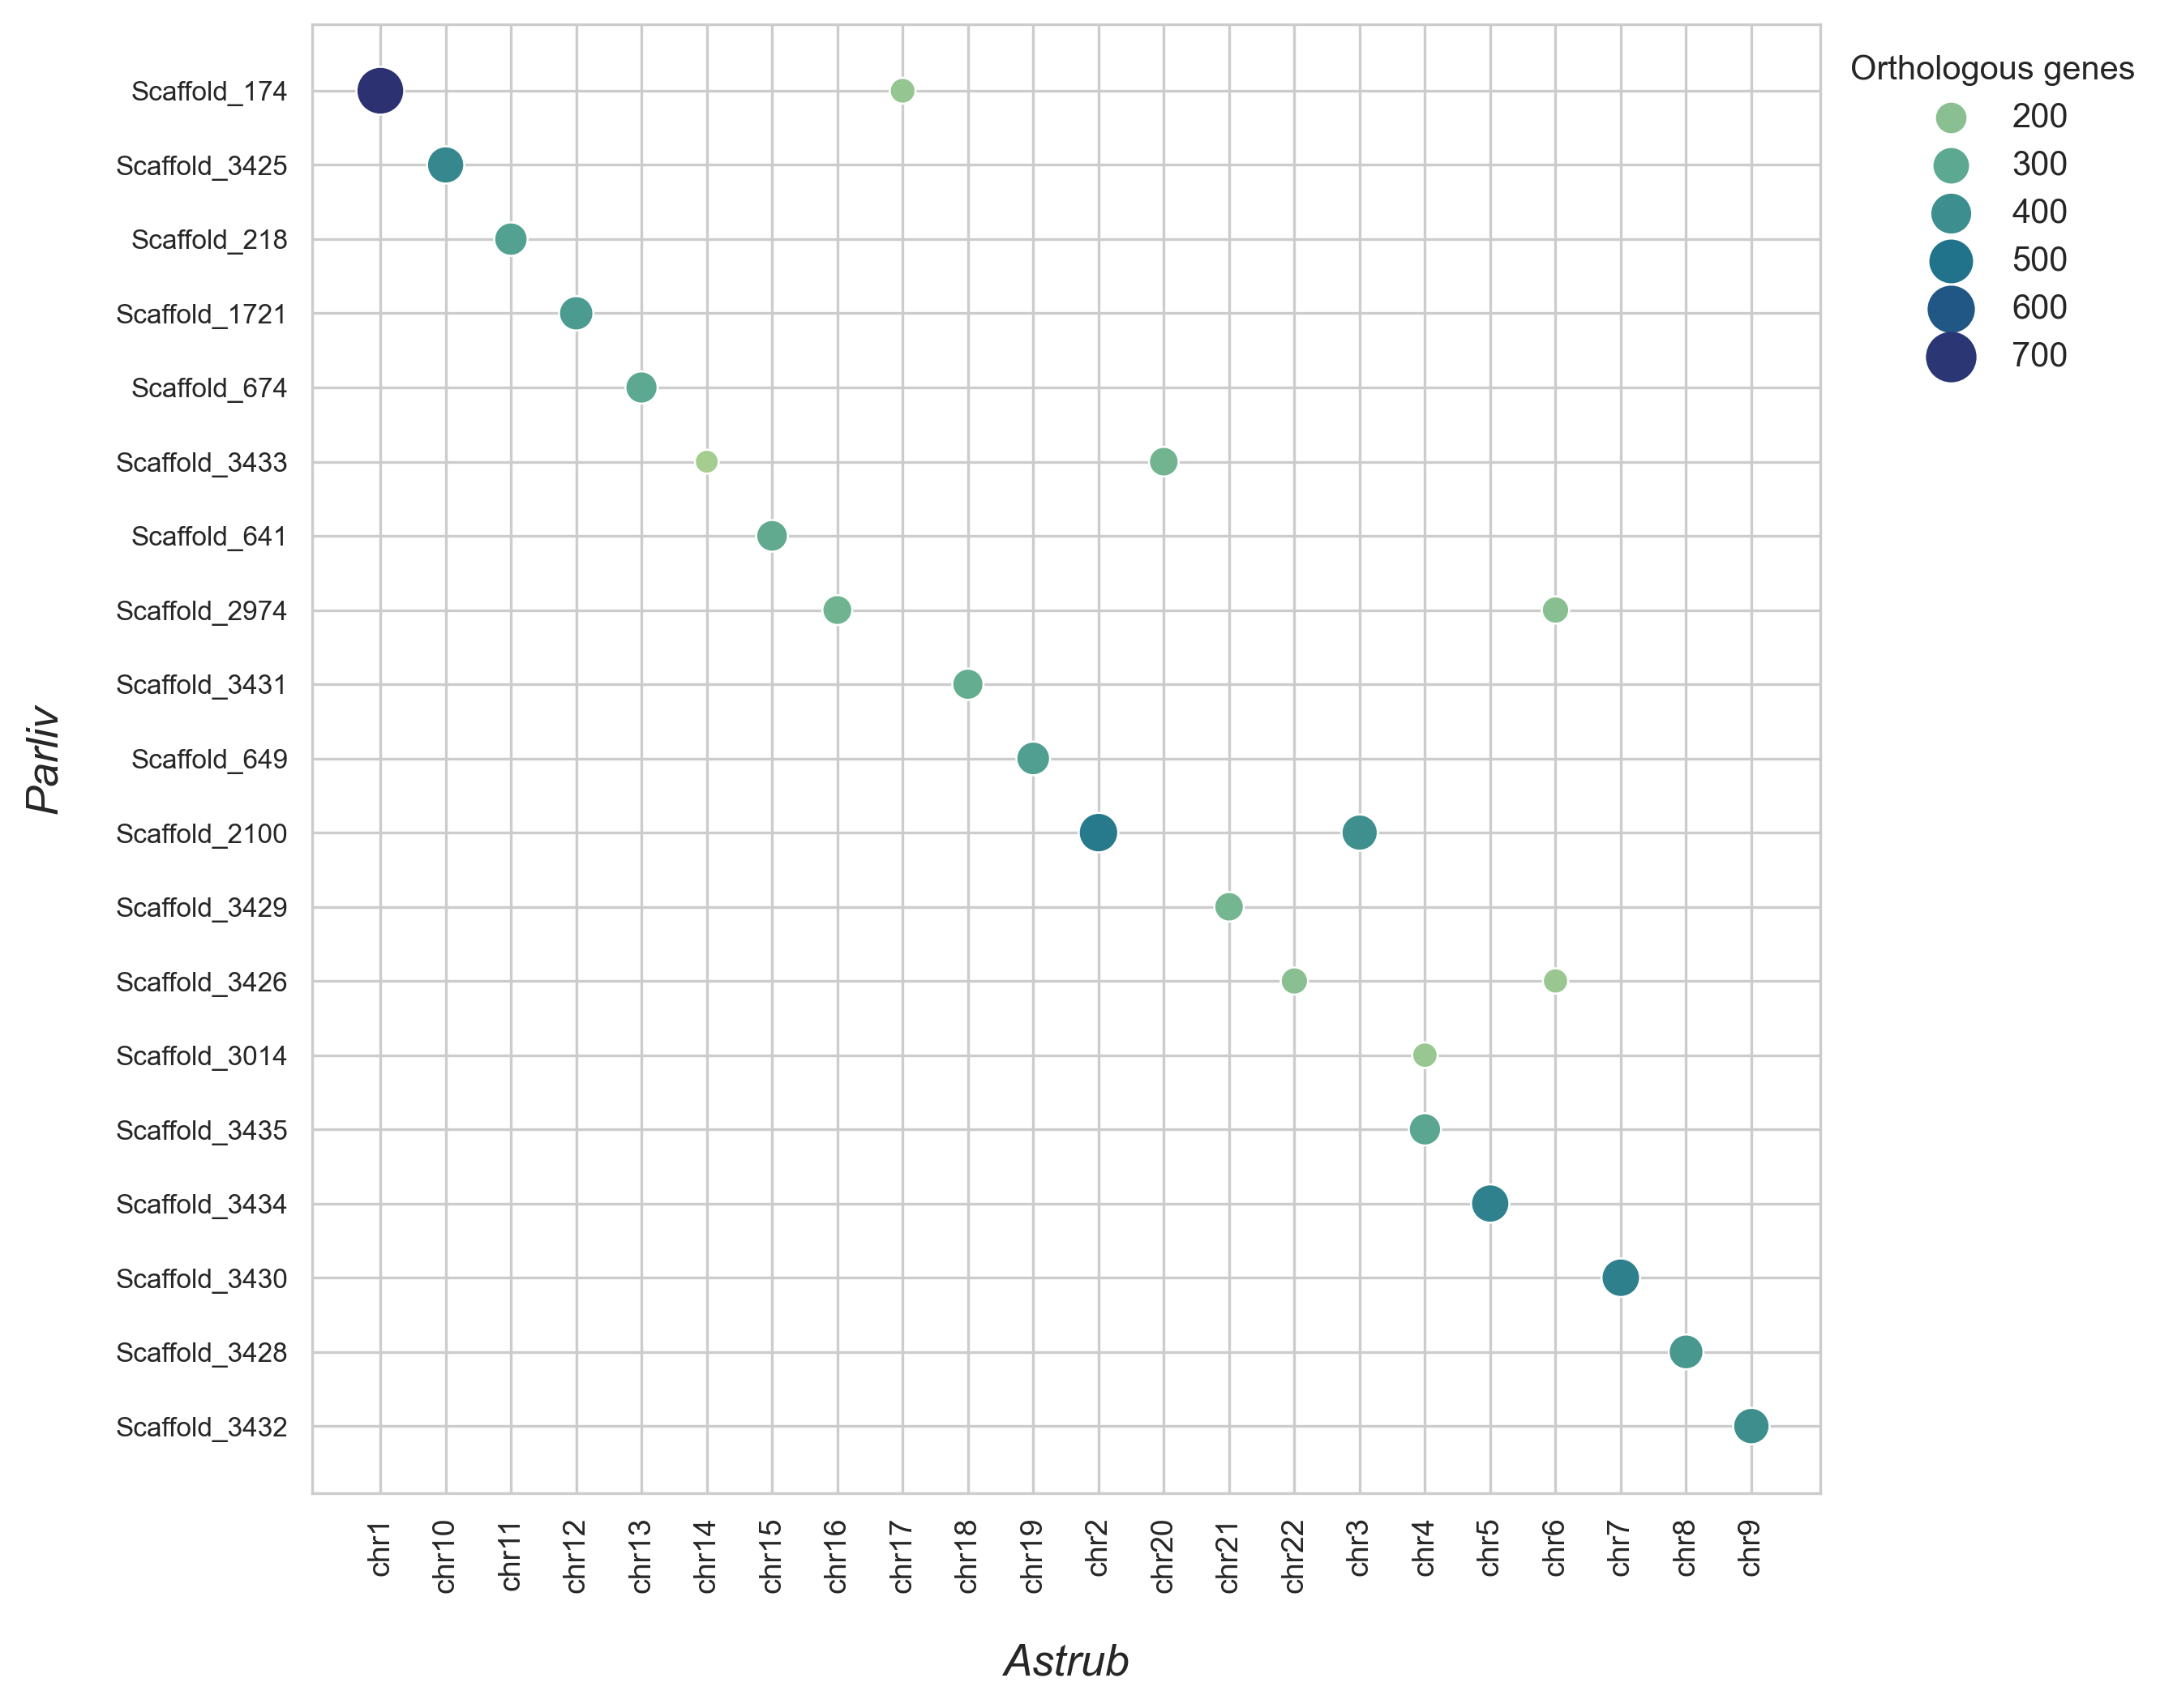

In [15]:
syntiny.orthoplot(syntiny.sigorthologies(Astrub, Parliv, Astrub_Parliv), 'Astrub', 'Parliv')

------------------------------

### Test simulations

In [16]:
# Function to standardise event output
def standardize(df):
    df = df.sort_values(['B']).astype(str).reset_index(drop = True)
    return df.applymap(lambda x: ', '.join(sorted(re.split(', *', x)))
                       if isinstance(x, str) else x)

In [18]:
# Run simulator
simancestor, simspeciesA, simorthologs, simevents = syntiny.simulator()

algevents = syntiny.rearrangements(syntiny.orthologies(simancestor,
                                                               simspeciesA,
                                                               simorthologs))
matches = []
mismatches = []

simevents = simevents.set_index('B')
algevents = algevents.set_index('B').reindex(simevents.index)

out = standardize(simevents).eq(standardize(algevents))

# Print number of matches
if np.all(out) == True: 
    
    matches.append(10)

else:
    mm = (standardize(simevents).compare(standardize(algevents)).iloc[:, 0]).tolist()
    mismatches.append(mm)
    matches.append(10 - len(mm))
    
    
print(matches)

[10]


In [19]:
simevents

,Events,A
B,,
Chr9;10,TRA,"AncChr10, AncChr9"
"Chr8_1, Chr8_2",FIS,AncChr8
Chr14;13,TRA,"AncChr13, AncChr14"
Chr16+3,FUS,"AncChr16, AncChr3"
"Chr5_1, Chr5_2",FIS,AncChr5
Chr11x12,FUS,"AncChr11, AncChr12"
Chr4x15,FUS,"AncChr4, AncChr15"
"Chr2_1, Chr2_2",FIS,AncChr2
"Chr6_1, Chr6_2",FIS,AncChr6


In [20]:
algevents

,Events,A
B,,
Chr9;10,TRA,"AncChr10, AncChr9"
"Chr8_1, Chr8_2",FIS,AncChr8
Chr14;13,TRA,"AncChr13, AncChr14"
Chr16+3,FUS,"AncChr16, AncChr3"
"Chr5_1, Chr5_2",FIS,AncChr5
Chr11x12,FUS,"AncChr11, AncChr12"
Chr4x15,FUS,"AncChr15, AncChr4"
"Chr2_1, Chr2_2",FIS,AncChr2
"Chr6_1, Chr6_2",FIS,AncChr6


In [21]:
# Run simulator and test function for 100 sets of events
def standardize(df):
    df = df.sort_values(['B']).astype(str).reset_index(drop = True)
    return df.applymap(lambda x: ', '.join(sorted(re.split(', *', x)))
                       if isinstance(x, str) else x)

matches = []
mismatches = []
for i in range(100): 
    simancestor, simspeciesA, simorthologs, simevents = syntiny.simulator()
    
    algevents = syntiny.rearrangements(syntiny.orthologies(simancestor,
                                                               simspeciesA,
                                                               simorthologs))
    
    simevents = simevents.set_index('B')
    algevents = algevents.set_index('B').reindex(simevents.index)
    
    out = standardize(simevents).eq(standardize(algevents))
    
    if np.all(out) == True: 
        matches.append(10)
    
    else:
        mm = (standardize(simevents).compare(standardize(algevents)).iloc[:, 0]).tolist()
        mismatches.append(mm)
        matches.append(10 - len(mm))

    
print(matches)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Text(0, 0.5, 'Number of matches')

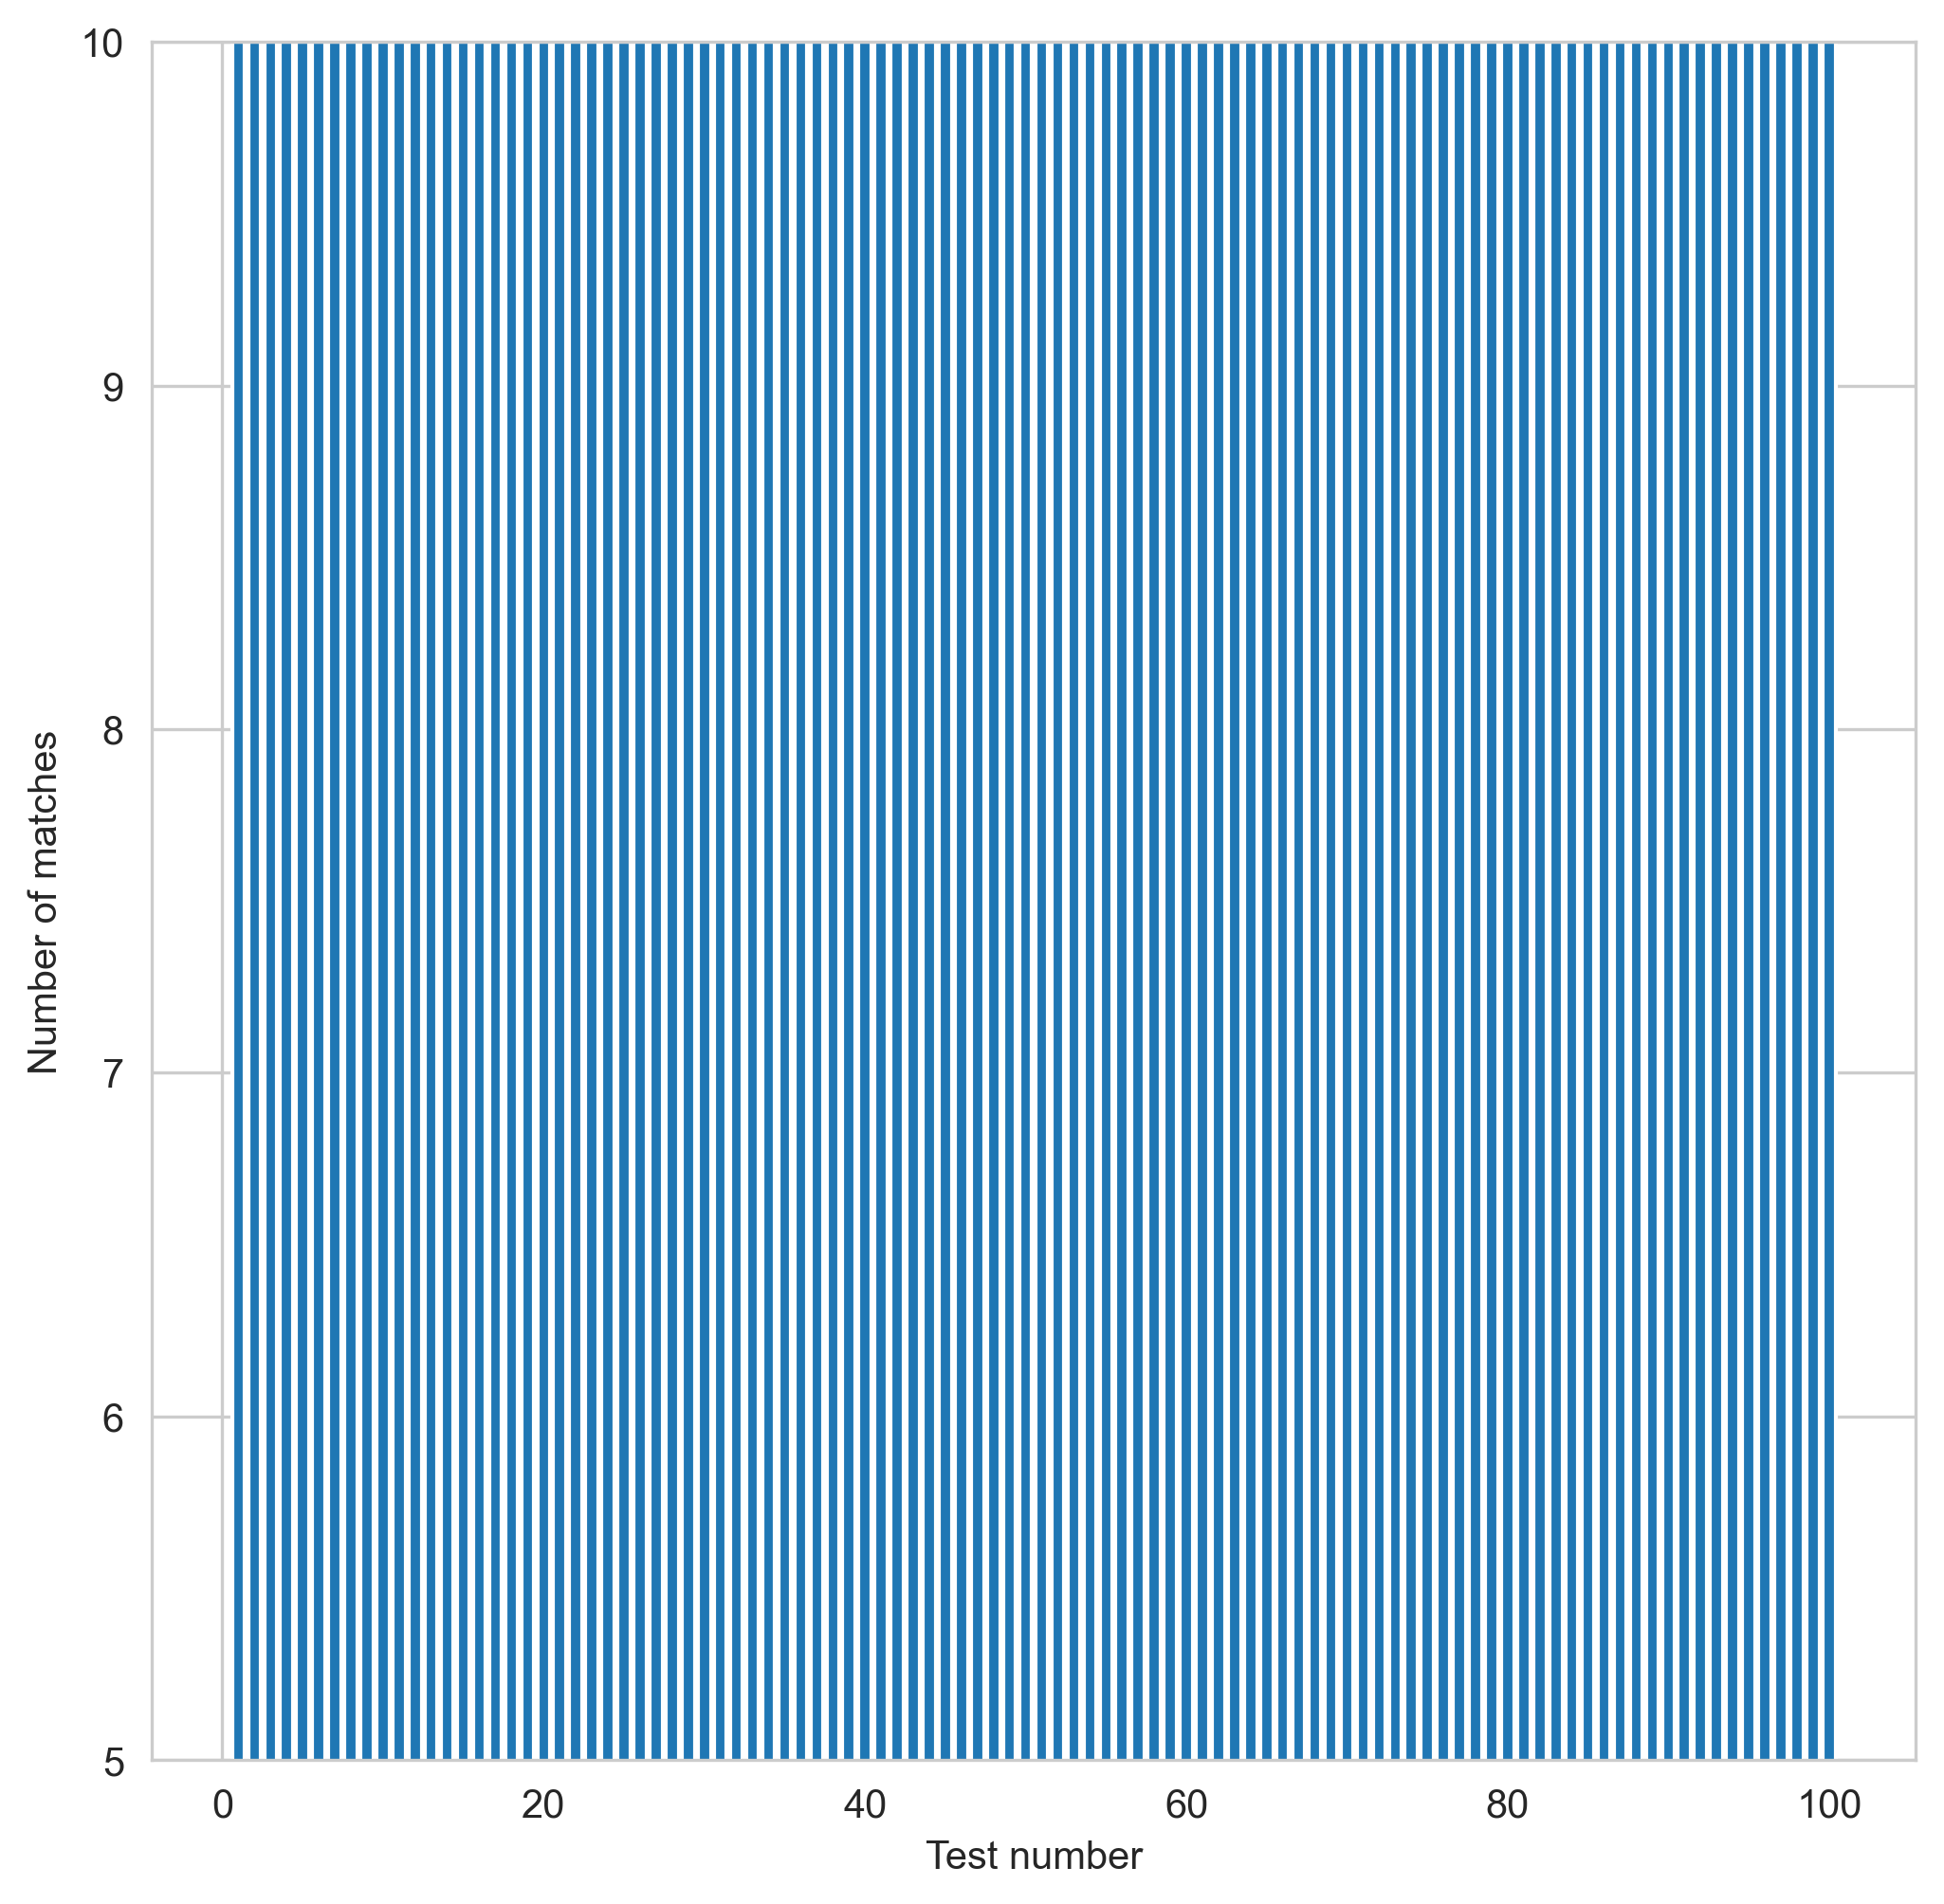

In [22]:
plt.bar(np.arange(1, 101), matches)
plt.xlabel('Test number')
plt.ylim(5, 10)
plt.ylabel('Number of matches')